<a href="https://colab.research.google.com/github/nitinranjansharma/EVA5B2/blob/main/s5/EVA4S5F9_experiment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Target: Reach 99.4% accuracy on validation using 10k params in 15 epochs
### 1. Process - Used Conv relu Conv block to forumalte the model
### 2. Results - Params - 9770
### 3. Best Train accuracy - 99.13
###    Best Test accuracy - 99.44
### 4. Analysis
###   a. The model has lesser number of params
###   b. Reduced dropout
###   c. Model stable after 10th Epoch but have a bit of fluctuation
###   d. Used scheduler to reduce fluctuations in training

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [ ]:
import torch.nn.functional as F
dropout_value = 0.08
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26, Receptive Field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 24, Receptive Field = 5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24, Receptive Field = 5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, Receptive Field = 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10, Receptive Field = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8, Receptive Field = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6, Receptive Field = 18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6, Receptive Field = 22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             100
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing



In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:

from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09213484078645706 Batch_id=468 Accuracy=86.14: 100%|██████████| 469/469 [00:42<00:00, 11.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0709, Accuracy: 9805/10000 (98.05%)

EPOCH: 1


Loss=0.04521201550960541 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:43<00:00, 10.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0594, Accuracy: 9835/10000 (98.35%)

EPOCH: 2


Loss=0.12049955129623413 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:42<00:00, 10.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9868/10000 (98.68%)

EPOCH: 3


Loss=0.020889028906822205 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:43<00:00, 10.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9881/10000 (98.81%)

EPOCH: 4


Loss=0.03428330644965172 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:44<00:00, 10.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9928/10000 (99.28%)

EPOCH: 5


Loss=0.0635627880692482 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:42<00:00, 11.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Loss=0.034164443612098694 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:41<00:00, 11.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.021939145401120186 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:42<00:00, 11.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.008158109150826931 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:43<00:00, 10.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.02297561801970005 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:43<00:00, 10.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


Loss=0.023857420310378075 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:44<00:00, 10.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)

EPOCH: 11


Loss=0.010610568337142467 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:42<00:00, 10.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.03713931515812874 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:42<00:00, 11.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Loss=0.021043211221694946 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:41<00:00, 11.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.05626573786139488 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:40<00:00, 11.72it/s]



Test set: Average loss: 0.0178, Accuracy: 9937/10000 (99.37%)



Text(0.5, 1.0, 'Test Accuracy')

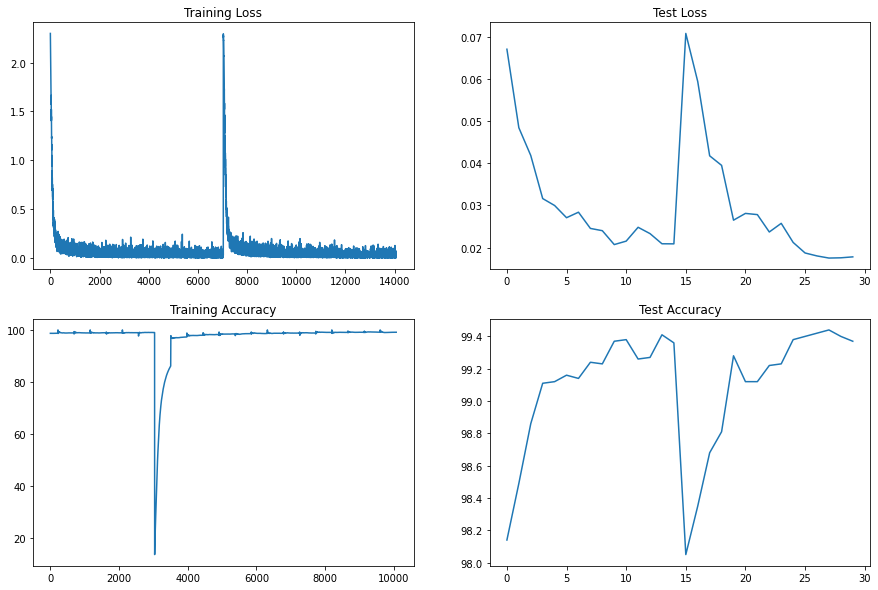